In [8]:
from data_management.data_acquisition import DataAcquisition
from data_management.data_transformation import DataTransformation
from data_management import FROM_CSV
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns

# 1 Data transformation

| Element of graph |                                                                   Usage in our case                                                                   | 
|:-----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------:| 
| Nodes            |                                                                         Teams                                                                         | 
| Nodes Features   | altogether home wins, home losses, away win and away losses, all points scored by team, all points lost to another team until the end of the snapshot | 
| Edges            |                                                           Matches between individual teams                                                            | 
| Edge features    |                                           0 - home win, 1 - draw, 2 - away win => match outcome prediction                                            |
| Node labels      |                             individual teams strength score starting at _S_0_  (could be different for different models)                              |


What type of graph do we have? - Number of vertices in our graphs is static - it is the number of all teams that we want to train on. Number of edges changes over time. Edges represent matches. So the graph is dynamic. Some vertices may not be connected in each graph snapshot, because there may be season, in which a team may not have played any match within selected league. Although this will create a redundancy in our feature matrix, it is more straightforward to implement, than reindexing teams in each snapshot in order to incorporate only those vertices with edges. So we are dealing with so called 'Dynamic graph temporal signal'.

2024-02-03 13:20:34.185 | INFO     | data_management._data_saving_loading:load_data_csv:70 - 21100 rows loaded from ../resources/other_leagues.csv


2012-09-25 18:00:00 2024-11-14 20:45:00


<Axes: xlabel='index', ylabel='matches_in_snapshot'>

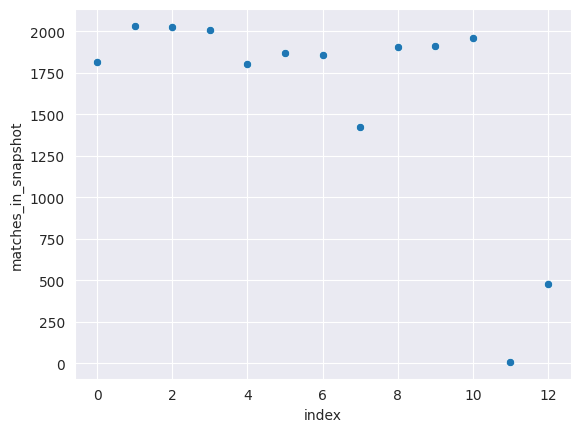

In [9]:
da = DataAcquisition()
df = da.get_data(FROM_CSV, fname="../resources/other_leagues.csv")

# see how many matches occupy each graph snapshot
df['DT'] = pd.to_datetime(df['DT'], format="%Y-%m-%d %H:%M:%S")

start_date = min(df['DT'])
end_date = max(df['DT'])
print(start_date, end_date)
delta = timedelta(days=365) # 1 season duration is about 6 months, then there are 6 months when no league tournaments are played
snapshots = []

while start_date <= end_date:
    snapshots.append(df[((start_date + delta >= df['DT']) & (start_date <= df['DT']))].shape[0])
    start_date += delta
    
sns.scatterplot(x="index", y="matches_in_snapshot", data=pd.DataFrame(snapshots, columns=["matches_in_snapshot"]).reset_index())

    

We can see that in each snapshot (representing 1 year), there are about 1800 matches in selected leagues altogether. That should be enough information for the graph neural network to learn from. But we need to try that first 

Normally methods showcased bellow are called from data_transform.transform() method, but in our case we want to see how they work


In [10]:
# constructor of DataTransformation class drops columns that are not used by our models
data_transform = DataTransformation(df, timedelta(365))

data_transform.df.head(5)

,DT,Home,Away,Winner,Home_points,Away_points
0,2024-11-12 17:00:00,Srsni Pisek,Slavia Prague,away,104,69
1,2024-11-11 17:45:00,Kolin,Usti n. Labem,home,112,108
2,2024-11-11 17:30:00,Pardubice,Decin,away,64,99
3,2024-11-11 17:00:00,Opava,NH Ostrava,home,80,75
4,2024-11-11 15:30:00,Brno,USK Prague,home,75,63


### 1.1 map teams to unique ids and match outcomes to integer values

| Winner | Integer value in table | 
|:-------|:----------------------:|
| Home   |           0            | 
| Away   |           2            | 
| Draw   |           1            | 

In [11]:
data_transform._create_teams_mapping()
data_transform._map_match_outcomes(verbose=True)
data_transform.df.head(5)

2024-02-03 13:20:34.591 | INFO     | data_management.data_transformation:_map_match_outcomes:40 - There are 12393 home wins, 6 draws and 8701 away wins in the dataset


,DT,Home,Away,Winner,Home_points,Away_points
0,2024-11-12 17:00:00,0,6,2,104,69
1,2024-11-11 17:45:00,1,10,0,112,108
2,2024-11-11 17:30:00,2,9,2,64,99
3,2024-11-11 17:00:00,3,11,0,80,75
4,2024-11-11 15:30:00,4,8,0,75,63


### 1.2 Extract node features

recall that these are:

| Feature id     |     0     |     1      |      2      |    3     |     4      |      5      | 
|:---------------|:---------:|:----------:|:-----------:|:--------:|:----------:|:-----------:|
| Nodes Features | home wins | home draws | home losses | away win | away draws | away losses | 

All of these features are dynamic - they accumulate over time during snapshots. In our models we want to try to predict with and without those features

In [12]:
node_features = data_transform._extract_node_features()

print("len:", len(node_features))
print("snapshot 0 full shapes:", node_features[0].shape)
node_features[0][:10]

len: 0


IndexError: list index out of range